### Download the data

In [1]:
!wget https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv

--2022-10-04 20:16:40--  https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5998096 (5.7M) [text/plain]
Saving to: ‘AE_Data.csv’

AE_Data.csv         100%[===================>]   5.72M  --.-KB/s    in 0.05s   

2022-10-04 20:16:41 (112 MB/s) - ‘AE_Data.csv’ saved [5998096/5998096]



In [2]:
! pip install --quiet bertopic
! pip install --quiet pyLDAvis

     |████████████████████████████████| 90 kB 4.4 MB/s 
     |████████████████████████████████| 88 kB 6.8 MB/s 
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 636 kB 61.2 MB/s 
     |████████████████████████████████| 5.2 MB 49.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.9 MB 52.1 MB/s 
     |████████████████████████████████| 1.3 MB 63.1 MB/s 
     |████████████████████████████████| 163 kB 63.9 MB/s 
     |████████████████████████████████| 6.6 MB 41.9 MB/s 
     |████████████████████████████████| 1.1 MB 70.0 MB/s 


In [3]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [4]:
df = pd.read_csv('/content/AE_Data.csv')
df.head()

,title,abstract,label
0,antimicrobial impacts of essential oils on foo...,the antimicrobial activity of twelve essential...,0
1,purification and characterization of a cystein...,antimicrobial peptide (amp) crustin is a type ...,0
2,telavancin activity tested against gram-positi...,objectives: to reassess the activity of telava...,0
3,the in vitro antimicrobial activity of cymbopo...,background: it is well known that cymbopogon (...,0
4,screening currency notes for microbial pathoge...,fomites are a well-known source of microbial i...,0


## BERTopic - Out of the Box

In [5]:
# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

model = BERTopic(
                  vectorizer_model=vectorizer_model,
                  language='english', 
                  calculate_probabilities=True,
                  verbose=True
                )

In [6]:
topics, probs = model.fit_transform(df['abstract'])

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/130 [00:00<?, ?it/s]

2022-10-04 20:28:05,804 - BERTopic - Transformed documents to Embeddings
2022-10-04 20:28:44,859 - BERTopic - Reduced dimensionality
2022-10-04 20:28:46,230 - BERTopic - Clustered reduced embeddings


In [7]:
freq = model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,1036,-1_strains_activity_bacteria_andotherspecies
1,0,180,0_biofilm_oral_plaque_periodontal
2,1,129,1____
3,2,128,2_naocl_antimicrobial_microorganisms_agar
4,3,124,3_extracts_extract_activity_plants
5,4,114,4_ciprofloxacin_mgl_active_fluoroquinolones
6,5,110,5_resistance_isolates_resistant_susceptibility
7,6,108,6_utis_urinary_mic90s_urinary tract
8,7,103,7_blood_patients_blood culture_blood cultures
9,8,85,8_ceftobiprole_ceftaroline_ceftazidime_cephalo...


In [8]:
model.visualize_barchart()

In [9]:
model.visualize_topics()

In [10]:
model.visualize_hierarchy()

### Data Cleaning

Out-of-the-Box solution has few evident issues - 
1. Too many Topics - Ideally we'd like to summarize the data in under fewer topics
2. Records with null text - Need to remove the records with no text
3. Overlapping Topics - Intertopic Distance Map shows overlapping topics, which shouldn't be the case

In order to clear these issues, let's first start with data cleaning - 
1. Lower case the entire corpus
2. Remove Stop words, add #PADDING and -TI to the list
3. Remove punctuations
4. Lemmatize the corpus
5. Remove the records with blank text

In [11]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [12]:
eng_stopwords = stopwords.words('english')
stemmer = WordNetLemmatizer()

# Define few data specific stopwords
WORDS_TO_REMOVE = ['##padding##', 'ti-', 'ti -']

joined_words_to_remove = '|'.join(WORDS_TO_REMOVE)


def clean_text(x):
  # Lower case the text
  lower_x = x.lower()

  # Remove line breaks and tabs
  no_break_x = re.sub("\n|\r|\t", " ", lower_x)

  # Remove specific words
  no_waste_words_x = re.sub(joined_words_to_remove, " ", no_break_x)

  # Remove all non alphabet, numeral characters and spaces
  alpha_x = re.sub('[^0-9a-zA-Z ]+', ' ', no_waste_words_x)

  # Remove stopwords and lemmatize the word. Join at the end will also remove multi-spaces
  lemma_x = ' '.join([stemmer.lemmatize(word) for word in alpha_x.split() if word not in eng_stopwords])

  return lemma_x

# Apply cleaning function to the text field
df['clean_text'] = df['abstract'].apply(lambda x : clean_text(x))

In [13]:
cleaned_text = df[df['clean_text'].str.len() != 0]['clean_text'].values

In [14]:
# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

model_exp2 = BERTopic(
                      vectorizer_model=vectorizer_model,
                      language='english',
                      nr_topics = 10,
                      calculate_probabilities=True,
                      verbose=True
                    )

In [15]:
# Fit BERTopic model on cleaned data 
topics, probs = model_exp2.fit_transform(cleaned_text)

Batches:   0%|          | 0/124 [00:00<?, ?it/s]

2022-10-04 20:36:56,388 - BERTopic - Transformed documents to Embeddings
2022-10-04 20:37:22,853 - BERTopic - Reduced dimensionality
2022-10-04 20:37:24,113 - BERTopic - Clustered reduced embeddings
2022-10-04 20:37:35,113 - BERTopic - Reduced number of topics from 84 to 11


In [16]:
freq = model_exp2.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,2755,-1_specie_strain_bacteria_activity
1,0,167,0_specie_specie specie_biofilm_oral
2,1,154,1_extract_specie_activity_plant
3,2,144,2_compound_activity_specie_antibacterial
4,3,126,3_patient_endocarditis_case_infection
5,4,124,4_microgram_microgram ml_specie_ml
6,5,120,5_specie_antimicrobial_naocl_material
7,6,105,6_vaginal_woman_specie_bv
8,7,92,7_protein_plasmid_gene_lactobacillus
9,8,87,8_oil_essential oil_essential_specie


In [17]:
model_exp2.visualize_barchart()

In [18]:
model_exp2.visualize_topics()

### Experiment 3 - Remove short words

We can see the topics with short words like ml, il, bv etc. Let's see the topic distribution if we remove the words with length lt 5

In [19]:
cut_off_len = 5

def keep_long_words(x, cut_off):
  '''
  Function to remove words less than cut off length from a string
  '''
  return ' '.join(word for word in x.split() if len(word) > cut_off)

cleaned_text_long_words = [keep_long_words(i, cut_off_len) for i in cleaned_text]

In [20]:
# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

model_exp3 = BERTopic(
                      vectorizer_model=vectorizer_model,
                      language='english',
                      nr_topics = 10,
                      calculate_probabilities=True,
                      verbose=True
                    )

In [21]:
# Fit BERTopic model on cleaned data 
topics, probs = model_exp3.fit_transform(cleaned_text_long_words)

Batches:   0%|          | 0/124 [00:00<?, ?it/s]

2022-10-04 20:44:24,040 - BERTopic - Transformed documents to Embeddings
2022-10-04 20:44:49,579 - BERTopic - Reduced dimensionality
2022-10-04 20:44:51,187 - BERTopic - Clustered reduced embeddings
2022-10-04 20:45:00,390 - BERTopic - Reduced number of topics from 91 to 11


In [22]:
freq = model_exp3.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,2579,-1_specie_strain_specie specie_bacteria
1,0,226,0_patient_infection_specie_endocarditis
2,1,169,1_compound_activity_specie_antibacterial
3,2,162,2_extract_activity_specie_specie specie
4,3,154,3_specie_microgram_active_ciprofloxacin
5,4,153,4_protein_specie_binding_enzyme
6,5,109,5_vaginal_specie_lactobacillus_bacterial
7,6,108,6_acidophilus_lactobacillus_probiotic_intestinal
8,7,105,7_plasmid_vector_sequence_lactobacillus
9,8,99,8_resistance_specie_isolates_resistant


In [23]:
model_exp3.visualize_barchart()

In [24]:
model_exp3.visualize_topics()

## Latent Dirichlet Allocation

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(cleaned_text_long_words).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
print(tf_feature_names[0:5])

In [37]:
from sklearn.decomposition import LatentDirichletAllocation

# Define number of topics
number_of_topics = 10

# Init LDA model with # Topics
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

# Fit the model on data
model.fit(tf)

LatentDirichletAllocation(random_state=0)

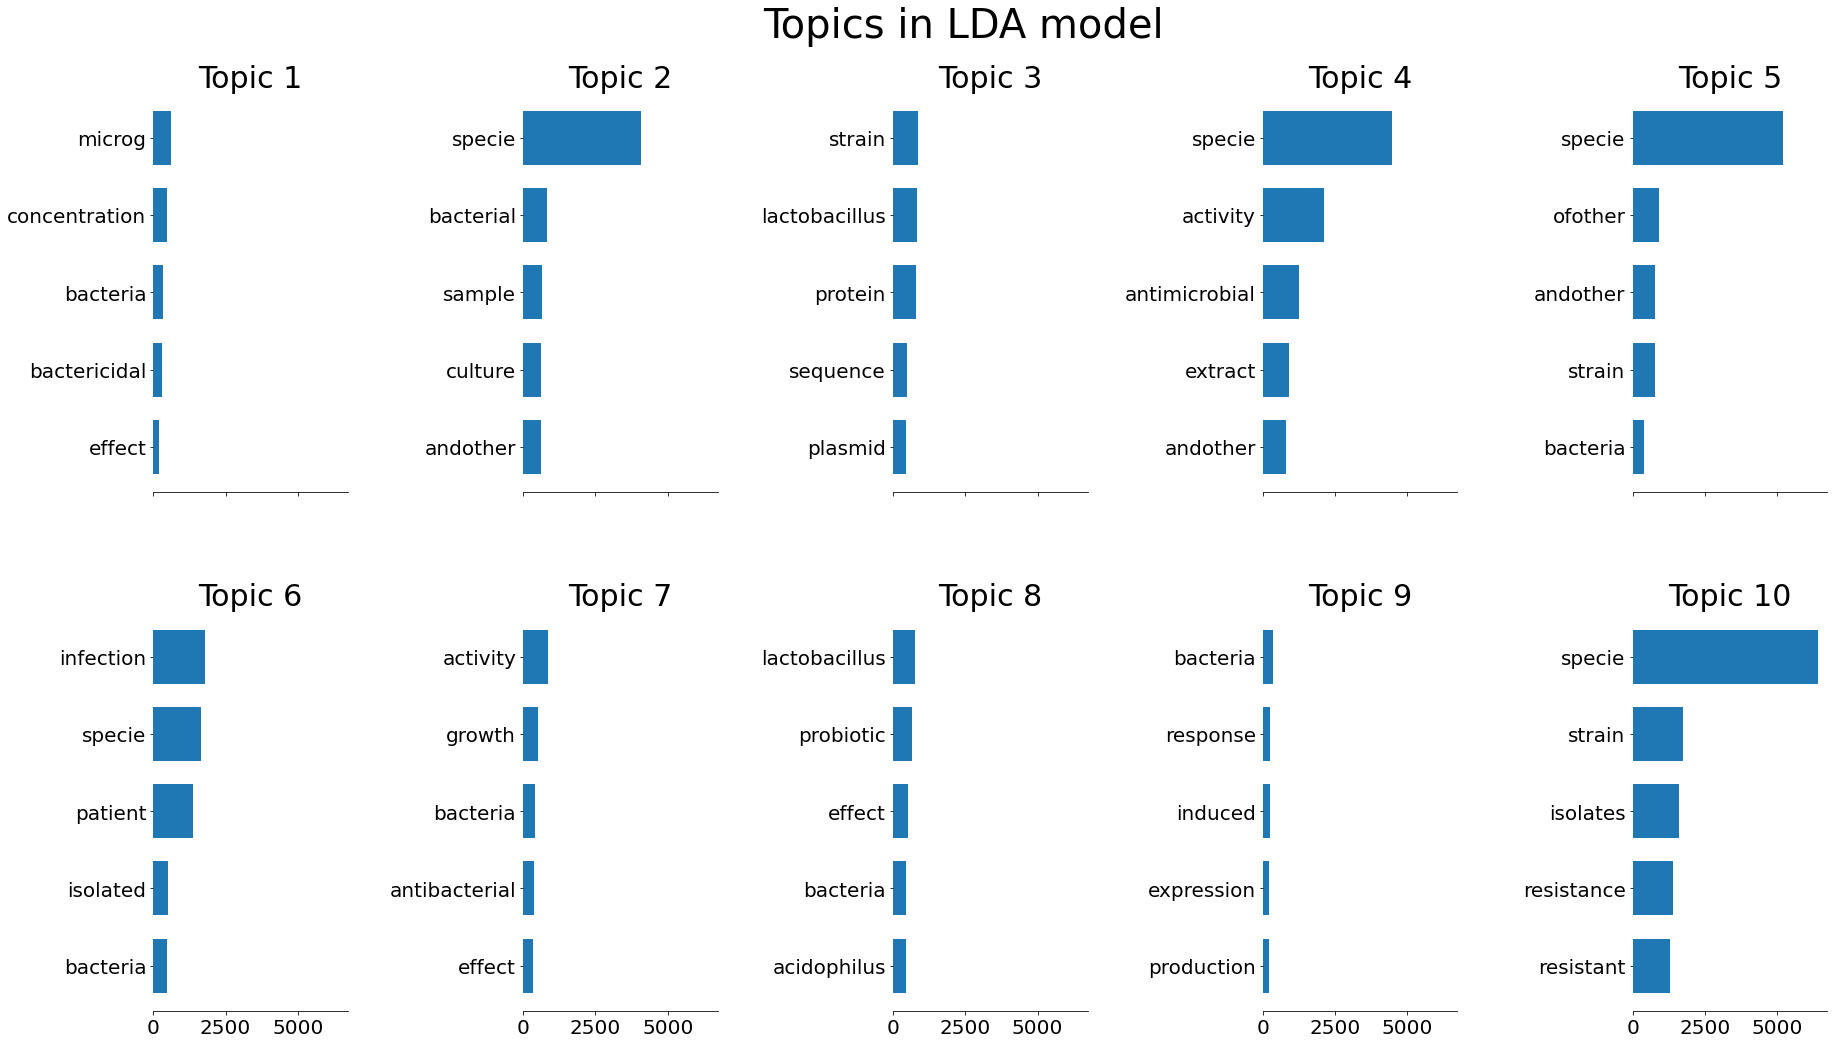

In [45]:
# Code from SKLearn docs

import matplotlib.pyplot as plt

n_top_words = 5

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(model, tf_feature_names, n_top_words, "Topics in LDA model")

In [48]:
# log-likelihood
print(model.score(tf))
# perplexity
print(model.perplexity(tf))

-1661815.510000308
414.30195472801375


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
import dill
import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()

In [57]:
# Prepare inputs for LDA visualization
tf = vectorizer.fit_transform(cleaned_text_long_words)

pyLDAvis.sklearn.prepare(model, tf, vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.081906 -0.271951       1        1  18.987587
3     -0.088846 -0.180713       2        1  14.883550
1      0.073219 -0.054634       3        1  13.292069
7     -0.101277  0.131709       4        1  10.387172
5      0.217267 -0.206052       5        1  10.217736
4      0.197507  0.043963       6        1   9.606693
2     -0.040223  0.286747       7        1   8.696097
6     -0.224404 -0.096121       8        1   6.728603
0     -0.292579  0.061417       9        1   3.704886
8      0.177430  0.285634      10        1   3.495606, topic_info=               Term          Freq         Total Category  logprob  loglift
1320         specie  22082.000000  22082.000000  Default  30.0000  30.0000
731       infection   2313.000000   2313.000000  Default  29.0000  29.0000
25         activity   4727.000000   4727.000000  Default  28.0000  28.0000
998         patient   1856.000000   1856.000000  Default  27.0000  27.0000
893          microg    806.000000    806.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
1045       positive     96.560677   2080.161805  Topic10  -4.6034   0.2836
938        negative     86.525163   1447.293869  Topic10  -4.7131   0.5366
519     escherichia     78.233317    773.939971  Topic10  -4.8139   1.0619
1106       property     70.379128    511.457413  Topic10  -4.9197   1.3703
1303  significantly     69.138828    680.129040  Topic10  -4.9375   1.0675

[628 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.045775  abdominal
0         4  0.091550  abdominal
0         5  0.854468  abdominal
1         1  0.013789    ability
1         2  0.057453    ability
...     ...       ...        ...
1527      2  0.023482  withother
1527      3  0.197916  withother
1527      4  0.140889  withother
1527      5  0.026836  withother
1527      6  0.469630  withother

[1982 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 2, 8, 6, 5, 3, 7, 1, 9])